# Calculate network routes between CHTS-derived origins and destinations

ignoring freeways for plausibility and using igraph + multiprocessing for fast simulation

In [1]:
import igraph as ig
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel
np.random.seed(0)

weight = 'length'
simulate_all_trips = True

## Load network and ODs

In [2]:
%%time
# load the networks
G_dir = ox.load_graphml('data/network/sf-directed-no-fwy.graphml')
G_undir = ox.load_graphml('data/network/sf-undirected-no-fwy.graphml')

CPU times: user 2.74 s, sys: 20.1 ms, total: 2.76 s
Wall time: 2.77 s


In [3]:
print(nx.is_strongly_connected(G_dir))
print(nx.is_connected(G_undir))

True
True


In [4]:
# load the origin-destination node pairs from CHTS
od_dir = pd.read_csv('data/od-directed-no-fwy.csv')
od_undir = pd.read_csv('data/od-undirected-no-fwy.csv')

# confirm the origins and destinations match between the two datasets
# (so we're simulating the same set of trips on each graph)
assert (od_dir['orig']==od_undir['orig']).sum() == len(od_dir) == len(od_undir)
assert (od_dir['dest']==od_undir['dest']).sum() == len(od_dir) == len(od_undir)
print(len(od_dir))

1594


## How many trips to simulate

In [5]:
# there are 1,133,333 daily trips that begin/end in SF
if simulate_all_trips:
    total_daily_trips = 1133333
    multiplier = total_daily_trips / len(od_dir)
    multiplier = math.ceil(multiplier)
else:
    multiplier = 1
multiplier

711

In [6]:
od_dir = pd.concat([od_dir]*multiplier, ignore_index=True)
len(od_dir)

1133334

In [7]:
od_undir = pd.concat([od_undir]*multiplier, ignore_index=True)
len(od_dir)

1133334

## Convert networkx graphs to igraph

In [8]:
# save osmid in attributes dict so we can retain it after integer-labeling nodes
for nodeid, data in G_dir.nodes().items():
    data['osmid'] = nodeid
for nodeid, data in G_undir.nodes().items():
    data['osmid'] = nodeid

In [9]:
G_dir = nx.relabel.convert_node_labels_to_integers(G_dir)
G_dir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_dir.nodes().items()}

G_undir = nx.relabel.convert_node_labels_to_integers(G_undir)
G_undir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_undir.nodes().items()}

In [10]:
%%time
# convert directed networkx graph to igraph
G_dir_ig = ig.Graph(directed=True)
G_dir_ig.add_vertices(list(G_dir.nodes()))
G_dir_ig.add_edges(list(G_dir.edges()))
G_dir_ig.vs['osmid'] = list(nx.get_node_attributes(G_dir, 'osmid').values())
G_dir_ig.es[weight] = list(nx.get_edge_attributes(G_dir, weight).values())

assert len(G_dir.nodes()) == G_dir_ig.vcount()
assert len(G_dir.edges()) == G_dir_ig.ecount()

CPU times: user 54.3 ms, sys: 646 µs, total: 55 ms
Wall time: 54.3 ms


In [11]:
%%time
# convert undirected networkx graph to igraph
G_undir_ig = ig.Graph(directed=False)
G_undir_ig.add_vertices(list(G_undir.nodes()))
G_undir_ig.add_edges(list(G_undir.edges()))
G_undir_ig.vs['osmid'] = list(nx.get_node_attributes(G_undir, 'osmid').values())
G_undir_ig.es[weight] = list(nx.get_edge_attributes(G_undir, weight).values())

assert len(G_undir.nodes()) == G_undir_ig.vcount()
assert len(G_undir.edges()) == G_undir_ig.ecount()

CPU times: user 42.3 ms, sys: 0 ns, total: 42.3 ms
Wall time: 41.7 ms


# Simulate routes between origins and destinations

In [12]:
def network_distance(G_ig, source, target, weight):
    try:
        return G_ig.shortest_paths(source=source, target=target, weights=weight)[0][0]
    except:
        return np.nan

def mp_paths(G_ig, orig, dest, weight, mapper):
    sources = (mapper[o] for o in orig)
    targets = (mapper[d] for d in dest)
    args = ((G_ig, s, t, weight) for s, t in zip(sources, targets))
    pool = mp.Pool(mp.cpu_count())
    sma = pool.starmap_async(network_distance, args)  
    results = sma.get()
    pool.close()
    pool.join()
    return results

In [13]:
%%time
# edges traversed along the real-world directed graph
G_ig = G_dir_ig
df = od_dir
mapper = G_dir_nodeid_to_osmid
w = None
col = 'edges_traversed'
df[col] = mp_paths(G_ig, df['orig'], df['dest'], w, mapper)

CPU times: user 3.17 s, sys: 252 ms, total: 3.42 s
Wall time: 59.6 s


In [14]:
%%time
# edges traversed along the bidirectional undirected graph
G_ig = G_undir_ig
df = od_undir
mapper = G_undir_nodeid_to_osmid
w = None
col = 'edges_traversed'
df[col] = mp_paths(G_ig, df['orig'], df['dest'], w, mapper)

CPU times: user 2.23 s, sys: 212 ms, total: 2.44 s
Wall time: 1min 1s


In [15]:
%%time
# meters traveled along the real-world directed graph
G_ig = G_dir_ig
df = od_dir
mapper = G_dir_nodeid_to_osmid
w = weight
col = 'meters_traveled'
df[col] = mp_paths(G_ig, df['orig'], df['dest'], w, mapper)

CPU times: user 3.49 s, sys: 273 ms, total: 3.76 s
Wall time: 1min 31s


In [16]:
%%time
# meters traveled along the bidirectional undirected graph
G_ig = G_undir_ig
df = od_undir
mapper = G_undir_nodeid_to_osmid
w = weight
col = 'meters_traveled'
df[col] = mp_paths(G_ig, df['orig'], df['dest'], w, mapper)

CPU times: user 2.32 s, sys: 257 ms, total: 2.58 s
Wall time: 1min 17s


# Analysis

### Topological distance (blocks traversed)

In [17]:
left = od_dir['edges_traversed'].describe().round(2)
left.name = 'edges_traversed_dir'
right = od_undir['edges_traversed'].describe().round(2)
right.name = 'edges_traversed_undir'
pd.concat([left, right], axis='columns')

,edges_traversed_dir,edges_traversed_undir
count,1133334.00,1133334.00
mean,40.17,38.03
std,21.88,20.72
min,0.00,0.00
25%,23.00,22.00
50%,39.00,37.00
75%,54.00,52.00
max,104.00,103.00


In [18]:
# are the average blocks-traveled per trip significantly different?
a = od_dir['edges_traversed']
b = od_undir['edges_traversed']
diff = a.mean() - b.mean()
t, p = ttest_rel(a=a, b=b, alternative='greater', nan_policy='omit')
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t, p))

n=1133334, δ=2.13, t=1053.79, p=0.0000


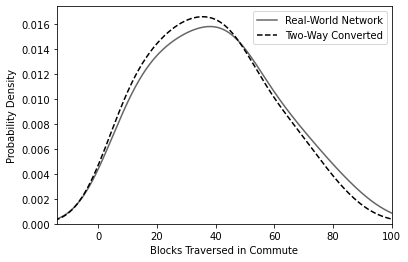

In [19]:
bw = 0.4
lw = 1.5
ax = a.plot.kde(label='Real-World Network', lw=lw, c='#666666', bw_method=bw)
ax = b.plot.kde(ax=ax, label='Two-Way Converted', lw=lw, c='k', ls='--', bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-14, right=100)
ax.set_xlabel('Blocks Traversed in Commute')
ax.set_ylabel('Probability Density')
plt.legend()
plt.show()

### Metric distance (meters traveled)

In [20]:
left = od_dir['meters_traveled'].describe().round(2)
left.name = 'meters_traveled_dir'
right = od_undir['meters_traveled'].describe().round(2)
right.name = 'meters_traveled_undir'
pd.concat([left, right], axis='columns')

,meters_traveled_dir,meters_traveled_undir
count,1133334.00,1133334.00
mean,5012.07,4930.81
std,2891.12,2870.99
min,0.00,0.00
25%,2769.25,2737.67
50%,4764.08,4684.48
75%,6857.63,6726.95
max,13592.14,13540.28


In [21]:
# are the average meters-traveled per trip significantly different?
a = od_dir['meters_traveled']
b = od_undir['meters_traveled']
diff = a.mean() - b.mean()
t, p = ttest_rel(a=a, b=b, alternative='greater', nan_policy='omit')
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t, p))

n=1133334, δ=81.26, t=763.23, p=0.0000


In [22]:
a.mean() / b.mean()

1.016479713435767

In [23]:
difference = a - b
difference.describe().round(3)

count    1133334.000
mean          81.258
std          113.342
min           -0.000
25%            3.958
50%           31.239
75%          120.617
max         1054.013
Name: meters_traveled, dtype: float64

In [24]:
# what % of trips had an increase between 1-way vs 2-way scenarios
(difference > 0).sum() / len(difference)

0.8569636135508155

In [25]:
# of trips that did increase, what is the mean?
difference[difference > 0].describe().round(2)

count    971226.00
mean         94.82
std         117.07
min           0.00
25%          13.05
50%          46.40
75%         146.76
max        1054.01
Name: meters_traveled, dtype: float64

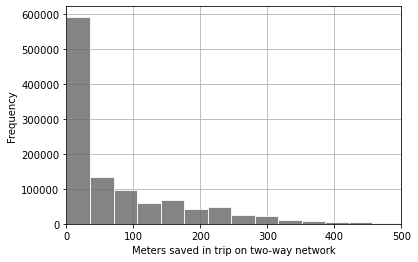

In [26]:
ax = difference.plot.hist(bins=30, ec='w', color='#666666', alpha=0.8, zorder=2)
ax.set_xlim(left=0, right=500)
ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_xlabel('Meters saved in trip on two-way network')
plt.show()

# Surplus VKT and fuel consumption 

In [27]:
# converters
miles_to_km = 1.60934 #factor to convert miles to km
mpg_to_kpl = 0.425144 #factor to convert fuel economy miles/gallon to km/liter
lb_per_gal_to_kg_per_liter = 0.119826 #factor to convert emissions from lb/gal to kg/liter
co2_usd_ton = 50 #factor to convert metric tons of co2 to US dollars

#### Excess VKT per day and per year

What is the daily VKT in San Francisco? There are competing figures out there.

**SFCTA**'s TNCs Today report appears to estimate VMT for trips that both begin and end within the city: "Ride-hail vehicles drive approximately 570,000 vehicle miles within San Francisco on a typical weekday. This accounts for 20 percent of all local daily vehicle miles traveled" from https://www.sfcta.org/tncstoday

**CalTrans**'s 2017 Public Roads Data report appears to estimate all the VMT that occurs on the city's (county's) streets, even if the trip is just passing through SF (9,648,730 miles/day). https://dot.ca.gov/-/media/dot-media/programs/research-innovation-system-information/documents/prd2017.pdf

Finally, SFCTA estimates 1,133,333 occur each day entirely within SF. "On a typical weekday, ride-hail vehicles make more than 170,000 vehicle trips within San Francisco, approximately 12 times the number of taxi trips, representing 15 percent of all intra-San Francisco vehicle trips." from https://www.sfcta.org/tncstoday

CA carbon pricing is contemporaneously \$14.67 per 1000 kg (metric ton): https://www.eia.gov/todayinenergy/detail.php?id=34792 In Europe in 2021, it's around $50.

In [28]:
#sf_daily_vmt = 9648730    #CalTrans estimate (all trips through SF)
sf_daily_vmt = 570000 * 5 #SFCTA estimate (only trips entirely within SF)
sf_daily_vkt = int(sf_daily_vmt * miles_to_km)
sf_daily_vkt

4586619

In [29]:
# estimate surplus VKT per day
surplus_vkt_daily = int(sf_daily_vkt - (sf_daily_vkt / (a.mean() / b.mean())))
surplus_vkt_daily

74360

In [30]:
# estimate surplus VKT per year
surplus_vkt_annual = int(surplus_vkt_daily * 365)
surplus_vkt_annual

27141400

#### Excess Fuel Consumption and GHG Emission

Average US fuel economy is 24.7 miles/gallon: https://www.reuters.com/article/us-autos-emissions/u-s-vehicle-fuel-economy-rises-to-record-24-7-mpg-epa-idUSKBN1F02BX

Burning 1 gallon of gasoline releases 20 lbs of CO2: https://www.fueleconomy.gov/feg/contentIncludes/co2_inc.htm

In [31]:
# what is the average US fuel economy in km/liter?
fuel_econ_mpg = 24.7 #per reuters
fuel_econ_kpl = fuel_econ_mpg * mpg_to_kpl
fuel_econ_kpl

10.5010568

In [32]:
# how many surplus liters of fuel does this waste per year?
surplus_fuel_liters = surplus_vkt_annual / fuel_econ_kpl
int(surplus_fuel_liters)

2584635

In [33]:
# how many kg of CO2 are released from combusting 1 liter of gasoline?
co2_lbs_per_gal = 20 #per fueleconomy.gov
co2_kg_per_liter = co2_lbs_per_gal * lb_per_gal_to_kg_per_liter
co2_kg_per_liter

2.39652

In [34]:
# how many excess kg of CO2 are released each year?
co2_excess_kg = int(surplus_fuel_liters * co2_kg_per_liter)
co2_excess_kg

6194129

In [35]:
# price in USD for this excess CO2
co2_usd_ton * (co2_excess_kg / 1000)

309706.45

## Save to disk

In [36]:
left = od_dir
right = od_undir[['edges_traversed', 'meters_traveled']]
df = pd.merge(left, right, left_index=True, right_index=True, suffixes=('_dir', '_undir'))
df.head()

,SAMPN,PERNO,orig,dest,edges_traversed_dir,meters_traveled_dir,edges_traversed_undir,meters_traveled_undir
0,1033944,1,65335448,65303721,82,10458.656,79,10257.243
1,1049908,1,65334137,65305814,14,1552.525,12,1542.487
2,1051388,2,65298349,65303529,44,5849.107,41,5410.716
3,1051795,1,65294011,65352454,61,9085.323,59,8768.364
4,1069723,1,65301529,65317028,30,4095.276,30,4094.115


In [37]:
# save to disk
df.to_csv('data/od_distances-no-fwy-igraph.csv', index=False, encoding='utf-8')